# Optimizer Example
Jena Climate ANN example showing comparsion between Adam and *newer* optimizers.
This is a regression model, using 3-hour data.

Richard Henry, 18-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.16.2'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

# Jena ANN

In [5]:
# Load Data (Already cleaned and decimated)
df3=pd.read_csv('dataset/Jena_climate/cleanJena3.csv')

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23363 entries, 0 to 23362
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       23363 non-null  float64
 1   VPact (mbar)   23363 non-null  float64
 2   Tdew (degC)    23363 non-null  float64
 3   T (degC)       23363 non-null  float64
 4   max. wv (m/s)  23363 non-null  float64
 5   NSwind         23363 non-null  float64
 6   EWwind         23363 non-null  float64
 7   year           23363 non-null  int64  
 8   month          23363 non-null  int64  
 9   day            23363 non-null  int64  
 10  hour           23363 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 2.0 MB


In [7]:
df3.describe()

,p (mbar),VPact (mbar),Tdew (degC),T (degC),max. wv (m/s),NSwind,EWwind,year,month,day,hour
count,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000
mean,989.216246,9.533017,4.954671,9.456338,3.533382,-0.631798,-0.415655,2012.497068,6.517399,15.713222,10.500449
std,8.353071,4.184973,6.730860,8.428081,2.339862,1.983549,1.553730,2.289905,3.448433,8.799298,6.873702
min,942.720000,0.810000,-24.800000,-22.760000,0.000000,-10.783959,-7.148867,2009.000000,1.000000,1.000000,0.000000
25%,984.200000,6.220000,0.240000,3.340000,1.760000,-1.480647,-1.372670,2010.000000,4.000000,8.000000,6.000000
50%,989.590000,8.860000,5.210000,9.440000,2.980000,-0.637933,-0.296919,2012.000000,7.000000,16.000000,12.000000
75%,994.730000,12.360000,10.080000,15.480000,4.730000,0.306138,0.432981,2014.000000,10.000000,23.000000,15.000000
max,1015.170000,28.040000,22.940000,36.460000,18.780000,7.709359,6.966350,2017.000000,12.000000,31.000000,21.000000


In [8]:
# Model / data parameters
blk_len=16*8      #Look back at two weeks of data
stp_len=8         #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=64*8      #batch size of 2 months
epo_len=32         #32 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location

In [9]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,blk_len,col_len])
for i in range(cut_len):
    for j in range(blk_len):
            xTrain[i][j][:]=xAll[i+j][:]

CPU times: total: 2.09 s
Wall time: 2.23 s


In [10]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [11]:
# Build & train model function
def model_build(myOpti):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(blk_len,col_len)),
            fixMe,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64,
                                  activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32,
                                  activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1,
                                  activation='linear')
        ]
    )
    model.compile(loss='mean_squared_error',
                  optimizer=myOpti,
                  metrics=['mean_absolute_error'])
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra)
    myPre=model.predict(xTrain)
    return myHis,myPre

### First Model, Adam

In [12]:
%%time
h0,p0=model_build('adam')

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 81.0280 - mean_absolute_error: 7.0217 - val_loss: 22.0413 - val_mean_absolute_error: 3.7381
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.1961 - mean_absolute_error: 3.9312 - val_loss: 16.0367 - val_mean_absolute_error: 3.1848
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.9272 - mean_absolute_error: 3.4776 - val_loss: 13.5145 - val_mean_absolute_error: 2.9434
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7993 - mean_absolute_error: 3.2048 - val_loss: 12.8552 - val_mean_absolute_error: 2.8344
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.3048 - mean_absolute_error: 3.0587 - val_loss: 13.0782 - val_mean_absolute_error: 2.8375
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.6002 - mean_absolute_error: 2.9877 - val_loss: 12.8446 - val_mean_absolute_error: 2.8128
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.8860 - mean_absolute_error: 2.9000 - va

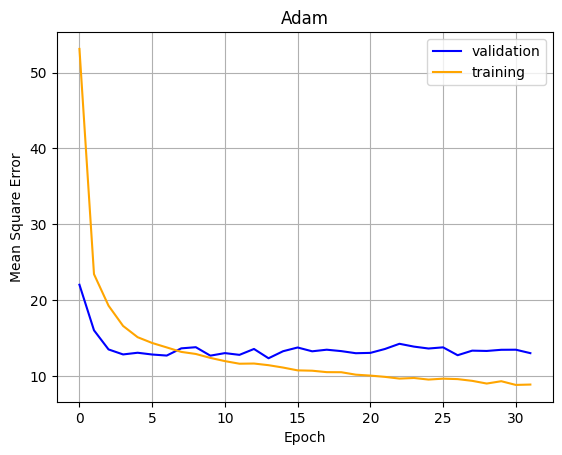

In [13]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h0.history['loss'], color='orange')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['validation','training'])
plt.title('Adam')
plt.grid()
plt.show()

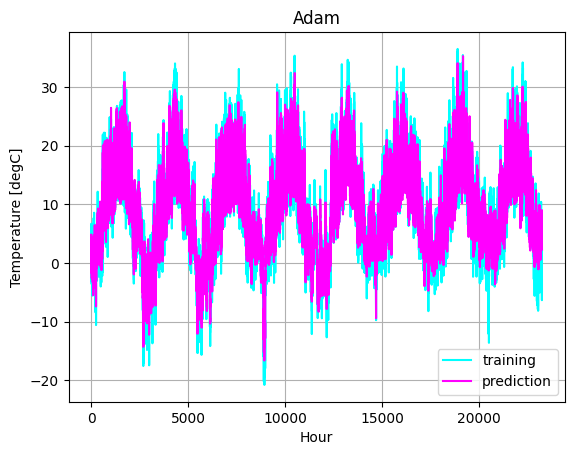

In [14]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam')
plt.grid()
plt.show()

In [15]:
#plt.plot(y_train, color='cyan')
#plt.plot(p0.flatten(), color='magenta')
#plt.ylabel('Temperature [degC]')
#plt.xlabel('Hour')
#plt.legend(['training','prediction'])
#plt.title('Adam (Final Year)')
#plt.grid()
#plt.xlim([60588,69348])
#plt.show()

In [16]:
#plt.plot(y_train, color='cyan')
#plt.plot(p0.flatten(), color='magenta')
#plt.ylabel('Temperature [degC]')
#plt.xlabel('Hour')
#plt.legend(['training','prediction'])
#plt.title('Adam (Final Month)')
#plt.grid()
#plt.xlim([68604,69348])
#plt.show()

In [17]:
#plt.plot(y_train, color='cyan')
#plt.plot(p0.flatten(), color='magenta')
#plt.ylabel('Temperature [degC]')
#plt.xlabel('Hour')
#plt.legend(['training','prediction'])
#plt.title('Adam (Final Week)')
#plt.grid()
#plt.xlim([69180,69348])
#plt.show()

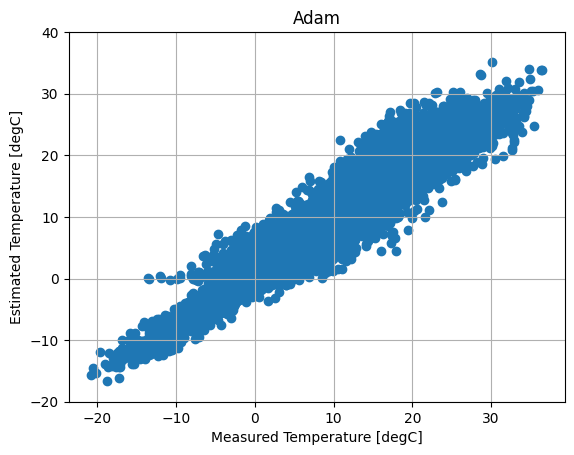

In [18]:
plt.scatter(y_train,p0.flatten())
plt.ylabel('Estimated Temperature [degC]')
plt.xlabel('Measured Temperature [degC]')
plt.title('Adam')
plt.grid()
plt.ylim([-20,40])
plt.show()

#### Commentary
Lorem Ipsum
### Second Model, Adam with Weight Decay

In [19]:
%%time
h1,p1=model_build('adamw')

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 72.0621 - mean_absolute_error: 6.6160 - val_loss: 20.1204 - val_mean_absolute_error: 3.6299
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.7513 - mean_absolute_error: 3.7499 - val_loss: 15.8240 - val_mean_absolute_error: 3.1638
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.7139 - mean_absolute_error: 3.3014 - val_loss: 13.9199 - val_mean_absolute_error: 2.9545
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5249 - mean_absolute_error: 3.1859 - val_loss: 13.2577 - val_mean_absolute_error: 2.8899
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.2988 - mean_absolute_error: 3.0585 - val_loss: 12.8540 - val_mean_absolute_error: 2.8140
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.2464 - mean_absolute_error: 2.9561 - val_loss: 12.5388 - val_mean_absolute_error: 2.7849
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.5300 - mean_absolute_error: 2.8701 - va

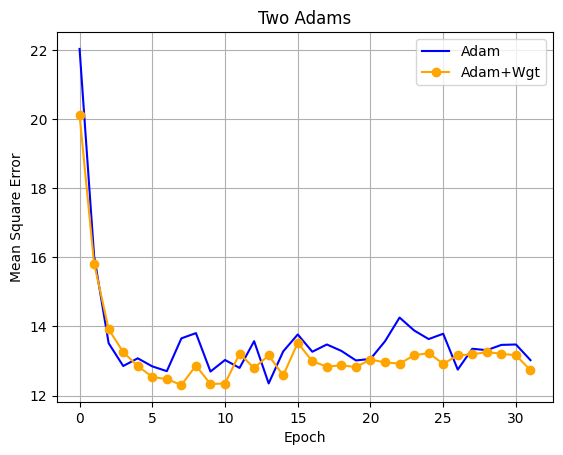

In [20]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h1.history['val_loss'], color='orange',marker='o')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt'])
plt.title('Two Adams')
plt.grid()
plt.show()

#### Commentary
Lorem Impsum
### Third Model, AdaFactor

In [21]:
%%time
h2,p2=model_build('adafactor')

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 164.6266 - mean_absolute_error: 10.7188 - val_loss: 187.7084 - val_mean_absolute_error: 11.7141
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 133.3102 - mean_absolute_error: 9.5873 - val_loss: 156.0618 - val_mean_absolute_error: 10.6082
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 103.8743 - mean_absolute_error: 8.4087 - val_loss: 124.4434 - val_mean_absolute_error: 9.4011
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 75.2565 - mean_absolute_error: 7.0478 - val_loss: 93.7874 - val_mean_absolute_error: 8.0390
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53.0662 - mean_absolute_error: 5.7890 - val_loss: 69.4301 - val_mean_absolute_error: 6.7483
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 41.2347 - mean_absolute_error: 5.0460 - val_loss: 53.5132 - val_mean_absolute_error: 5.8176
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.4412 - mean_absolute_error: 4.

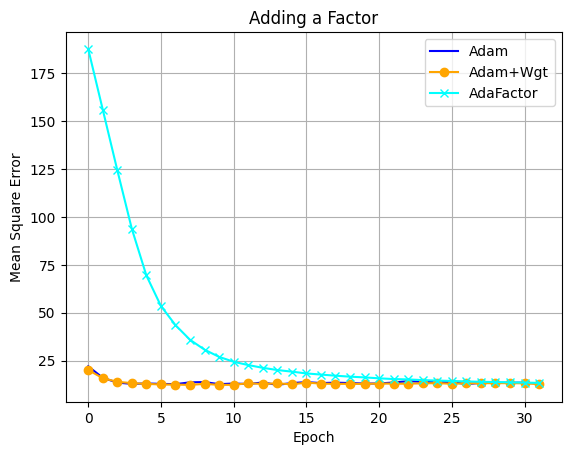

In [22]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','AdaFactor'])
plt.title('Adding a Factor')
plt.grid()
plt.show()

#### Commentary
Lorem Impsum
### Fourth Model, LION

In [23]:
%%time
h3,p3=model_build('lion')

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 72.1109 - mean_absolute_error: 6.5700 - val_loss: 17.7860 - val_mean_absolute_error: 3.3144
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23.3039 - mean_absolute_error: 3.7752 - val_loss: 16.4760 - val_mean_absolute_error: 3.1588
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.3897 - mean_absolute_error: 3.5319 - val_loss: 15.5480 - val_mean_absolute_error: 3.0895
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.5766 - mean_absolute_error: 3.3637 - val_loss: 16.3085 - val_mean_absolute_error: 3.1692
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.3446 - mean_absolute_error: 3.2335 - val_loss: 16.5090 - val_mean_absolute_error: 3.1846
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.2834 - mean_absolute_error: 3.0527 - val_loss: 16.0384 - val_mean_absolute_error: 3.1646
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.2566 - mean_absolute_error: 2.9533 - va

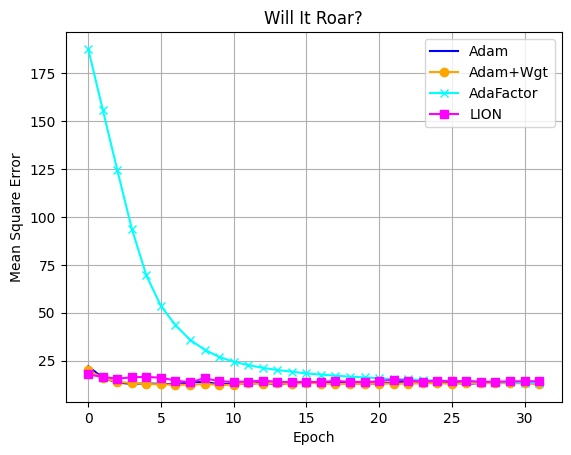

In [24]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.plot(h3.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','AdaFactor','LION'])
plt.title('Will It Roar?')
plt.grid()
plt.show()

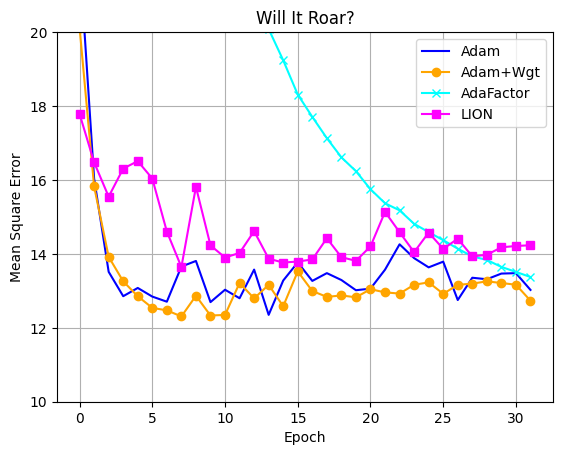

In [25]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.plot(h3.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','AdaFactor','LION'])
plt.title('Will It Roar?')
plt.ylim([10,20])
plt.grid()
plt.show()

5th Model, Adam with Nesterov Momentum

In [26]:
%%time
h4,p4=model_build('nadam')

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 83.3398 - mean_absolute_error: 7.1043 - val_loss: 20.2099 - val_mean_absolute_error: 3.6441
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.9392 - mean_absolute_error: 3.7631 - val_loss: 15.5092 - val_mean_absolute_error: 3.1204
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.2349 - mean_absolute_error: 3.3463 - val_loss: 13.8584 - val_mean_absolute_error: 2.9393
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.0438 - mean_absolute_error: 3.1383 - val_loss: 13.1229 - val_mean_absolute_error: 2.8465
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.8603 - mean_absolute_error: 3.0176 - val_loss: 12.9276 - val_mean_absolute_error: 2.8378
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.7241 - mean_absolute_error: 2.9017 - val_loss: 12.6243 - val_mean_absolute_error: 2.7760
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.0512 - mean_absolute_error: 2.8143 - va

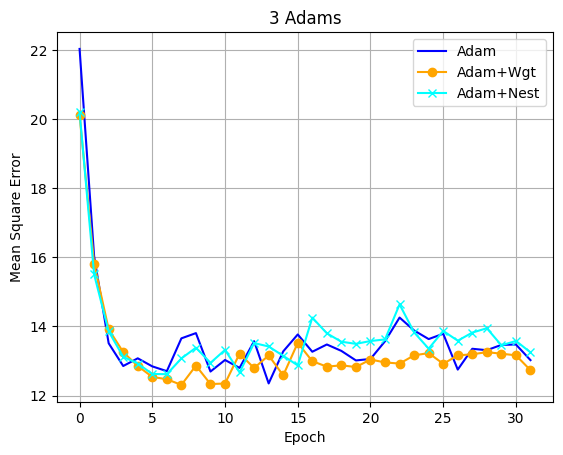

In [27]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h4.history['val_loss'],color='cyan',marker='x')
#plt.plot(h3.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','Adam+Nest','LION'])
plt.title('3 Adams')
plt.grid()
plt.show()

6th Model, Follow te Regularized Leader

In [28]:
%%time
h5,p5=model_build('ftrl')

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 97.2091 - mean_absolute_error: 7.9554 - val_loss: 75.9428 - val_mean_absolute_error: 7.1690
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.4274 - mean_absolute_error: 5.3840 - val_loss: 61.2918 - val_mean_absolute_error: 6.4001
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.2843 - mean_absolute_error: 4.9720 - val_loss: 48.7399 - val_mean_absolute_error: 5.6601
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.7336 - mean_absolute_error: 4.6026 - val_loss: 39.3752 - val_mean_absolute_error: 5.0577
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.2803 - mean_absolute_error: 4.2764 - val_loss: 32.1476 - val_mean_absolute_error: 4.5478
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.1037 - mean_absolute_error: 4.1068 - val_loss: 26.9364 - val_mean_absolute_error: 4.1429
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.1587 - mean_absolute_error: 3.9682 - va

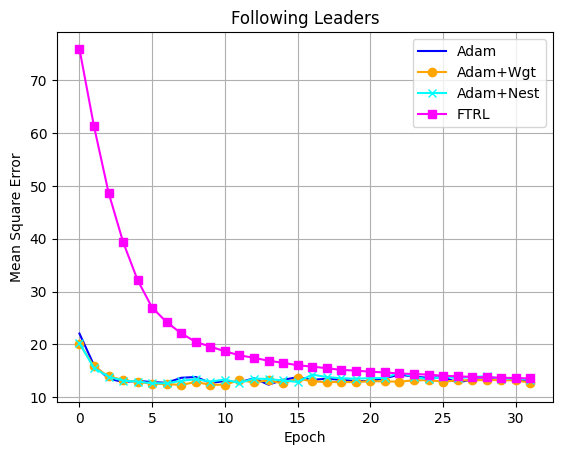

In [30]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h4.history['val_loss'],color='cyan',marker='x')
plt.plot(h5.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','Adam+Nest','FTRL'])
plt.title('Following Leaders')
plt.grid()
plt.show()

#### Commentary
Lorem Ipsum
# Conclusions
Blah blah blah